In [1]:
import sys
sys.path.append('..')
from pymavlink import mavutil
import matplotlib.pyplot as plt
import pandas as pd
import os
import geopandas as gpd
from shapely.geometry import Point, LineString

from sqlalchemy import create_engine

from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import POSTGRES_UTEA

RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

def obtener_engine():
    return create_engine(
        f"postgresql+psycopg2://{POSTGRES_UTEA['USER']}:{POSTGRES_UTEA['PASSWORD']}@{POSTGRES_UTEA['HOST']}:{POSTGRES_UTEA['PORT']}/{POSTGRES_UTEA['DATABASE']}"
    )

In [14]:
vehiculo = 'DA02'

In [15]:
if vehiculo == 'DA01':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_01'
elif vehiculo == 'DA02':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_02'
elif vehiculo == 'DA03':
    path_log = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Trichogramma\2025\TLOGS\ALTA_03'
contenido = os.listdir(path_log)
len(contenido)

319

In [16]:
gdf_rec = gpd.read_postgis(
    "SELECT * FROM drones_control_bio.recorridos_lib", 
    obtener_engine(), 
    geom_col='geom'  # columna con la geometría
)

In [17]:
gdf_rec.head()

,id,geom,idd,nombre,vehiculo,num_vert,asignado
0,1,"MULTILINESTRING ((471873.745 8084797.248, 4718...",-1,2025-05-02 08-32-28.tlog,DA02,2517.0,ORIGINAL
1,2,"MULTILINESTRING ((478886.299 8093597.535, 4788...",-1,2025-05-05 16-16-47.tlog,DA02,1056.0,ORIGINAL
2,247,"MULTILINESTRING ((474276.861 8075803.608, 4742...",616,2025-08-12 03-00-11.tlog,DA02,1710.0,None
3,248,"MULTILINESTRING ((473445.600 8076788.235, 4734...",616,2025-08-12 03-45-43.tlog,DA02,1605.0,None
4,249,"MULTILINESTRING ((469649.803 8090516.827, 4696...",617,2025-08-12 04-25-58.tlog,DA02,1988.0,None


In [18]:
# Filtrar la lista 'contenido' para excluir elementos que están en la columna 'nombre' del GeoDataFrame
contenido_filtrado = [item for item in contenido if item not in gdf_rec['nombre'].values]
len(contenido_filtrado)

16

In [19]:
contenido_filtrado

['2025-09-11 08-44-22.tlog',
 '2025-09-12 14-07-43.tlog',
 '2025-09-18 16-50-36.tlog',
 '2025-11-25 14-00-17.tlog',
 '2025-11-25 14-08-53.tlog',
 '2025-11-26 20-33-18.tlog',
 '2025-11-26 20-41-27.tlog',
 '2025-11-26 21-07-23.tlog',
 '2025-11-26 22-00-25.tlog',
 '2025-11-27 20-19-18.tlog',
 '2025-11-27 20-48-35.tlog',
 '2025-11-27 21-54-18.tlog',
 '2025-11-27 22-37-02.tlog',
 '2025-11-28 01-20-03.tlog',
 '2025-11-28 03-26-19.tlog',
 '2025-11-28 03-52-02.tlog']

In [20]:
def leer_logs(lista_logs):
    list_geo = []
    list_name = []
    for i in lista_logs:
        log = path_log + '/' + i
        
        name = i
        
        mlog = mavutil.mavlink_connection(log)
        lats = []
        lons = []
        while True:
            msg = mlog.recv_match()
            if not msg:
                break
            # Ejemplo de procesamiento de mensaje
            if msg.get_type() == 'GLOBAL_POSITION_INT':
                lat = msg.lat / 1e7  # Latitud en grados
                lon = msg.lon / 1e7  # Longitud en grados
                lats.append(lat)
                lons.append(lon)

        coors = {'lat':lats, 'lon':lons}
        df = pd.DataFrame(coors)
        
        geometry = [Point(xy) for xy in zip(df['lon'], df['lat'])]
        line = LineString(geometry)
        list_geo.append(line)
        list_name.append(name)
    return (list_geo, list_name)

In [21]:
lineas, names = leer_logs(contenido_filtrado)
lineas

ValueError: cannot mmap an empty file

In [151]:
# Crear un GeoDataFrame con los LineStrings y sus nombres
gdf_lines = gpd.GeoDataFrame({'nombre': names, 'geometry': lineas}, crs="EPSG:4326")
gdf_lines.head(3)

,nombre,geometry
0,2025-11-24 19-46-36.tlog,"LINESTRING (-62.97149 -17.21187, -62.97149 -17..."
1,2025-11-24 20-58-25.tlog,"LINESTRING (-62.97629 -17.22391, -62.97629 -17..."
2,2025-11-24 22-16-24.tlog,"LINESTRING (-62.98504 -17.23154, -62.98504 -17..."


In [152]:
# Función para contar la cantidad de coordenadas en una geometría de tipo LINESTRING
def contar_coordenadas(linea):
    return len(linea.coords)

# Función para dividir y limpiar las líneas
def dividir_y_limpiar_linea(linea):
    puntos = list(linea.coords)
    nuevas_lineas = []
    nueva_linea = []
    
    for punto in puntos:
        if punto != (0, 0):
            nueva_linea.append(punto)
        else:
            if nueva_linea:
                nuevas_lineas.append(LineString(nueva_linea))
                nueva_linea = []
    
    if nueva_linea:
        nuevas_lineas.append(LineString(nueva_linea))
    
    return nuevas_lineas

In [153]:
# Crear una lista para las nuevas líneas y nombres
nuevas_lineas = []
nuevos_nombres = []
for idx, row in gdf_lines.iterrows():
    lineas_divididas = dividir_y_limpiar_linea(row.geometry)
    for linea in lineas_divididas:
        nuevas_lineas.append(linea)
        nuevos_nombres.append(row['nombre'])

In [154]:
# Crear un nuevo GeoDataFrame con las nuevas líneas
gdf_lines = gpd.GeoDataFrame({'nombre': nuevos_nombres, 'geometry': nuevas_lineas}, crs="EPSG:4326")

In [155]:
gdf_lines['num_vert'] = gdf_lines['geometry'].apply(contar_coordenadas)
gdf_lines['vehiculo'] = vehiculo
gdf_lines.head(3)

,nombre,geometry,num_vert,vehiculo
0,2025-11-24 19-46-36.tlog,"LINESTRING (-62.97149 -17.21187, -62.97149 -17...",5774,DA03
1,2025-11-24 19-46-36.tlog,"LINESTRING (-62.97150 -17.21185, -62.97150 -17...",302,DA03
2,2025-11-24 19-46-36.tlog,"LINESTRING (-62.97149 -17.21185, -62.97149 -17...",3786,DA03


<Axes: >

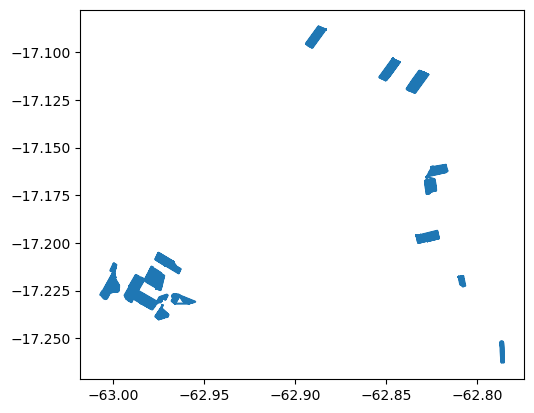

In [156]:
gdf_lines.plot()

In [157]:
gdf_lines.crs = "EPSG:4326"
gdf_lines_utm = gdf_lines.to_crs(epsg=32720)

<Axes: >

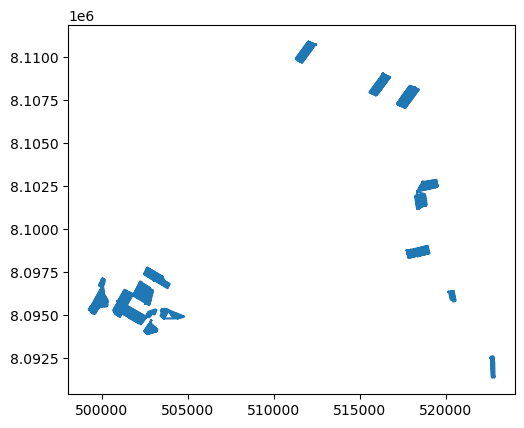

In [158]:
gdf_lines_utm.plot()

In [159]:
gdf_lines_utm['idd'] = 0
gdf_lines_utm = gdf_lines_utm.rename_geometry("geom")

In [160]:
gdf_lines_utm

,nombre,geom,num_vert,vehiculo,idd
0,2025-11-24 19-46-36.tlog,"LINESTRING (503030.979 8097006.856, 503030.969...",5774,DA03,0
1,2025-11-24 19-46-36.tlog,"LINESTRING (503030.054 8097008.261, 503030.065...",302,DA03,0
2,2025-11-24 19-46-36.tlog,"LINESTRING (503030.831 8097008.084, 503030.831...",3786,DA03,0
3,2025-11-24 20-58-25.tlog,"LINESTRING (502520.859 8095674.839, 502520.849...",5679,DA03,0
4,2025-11-24 20-58-25.tlog,"LINESTRING (502520.977 8095677.748, 502520.987...",4580,DA03,0
5,2025-11-24 22-16-24.tlog,"LINESTRING (501590.837 8094830.368, 501590.837...",1974,DA03,0
6,2025-11-24 22-16-24.tlog,"LINESTRING (501592.017 8094830.180, 501592.017...",5961,DA03,0
7,2025-11-24 23-03-15.tlog,"LINESTRING (500931.621 8095804.583, 500931.632...",3405,DA03,0
8,2025-11-24 23-41-01.tlog,"LINESTRING (500930.505 8095803.244, 500930.505...",4944,DA03,0
9,2025-11-25 00-34-22.tlog,"LINESTRING (500114.474 8096324.851, 500114.485...",2000,DA03,0


In [161]:
gdf_lines_utm.to_postgis(
    name="recorridos_lib",
    schema="drones_control_bio",
    con=obtener_engine(),
    if_exists="append",   # usa "replace" si quieres sobrescribir todo
    index=False
)